In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import torch
import torchio as tio
import SimpleITK as sitk

from torch.utils.data import DataLoader
from pathlib import Path

import utils
import cvae
import cvae_generate

In [4]:

# directorys with data and to store training checkpoints and logs
DATA_DIR = Path.cwd().parent.parent / "DevelopmentData"
CHECKPOINTS_DIR = Path.cwd() / "cvae_model_weights" / f"cvae_model_new_loss.pth"

In [23]:
import imp
imp.reload(utils)
# data settings 
IMAGE_SIZE = [64, 64]
BATCH_SIZE = 1390
Z_DIM = 256

# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if any(part.startswith("p") for part in path.parts)
]

cvae_data = [
    path
    for path in DATA_DIR.glob("*")
    if any(part.startswith("c") for part in path.parts)
]

# load training data and create DataLoader with batching and shuffling
dataset = utils.CombinedProstateMRDataset(patients, [], IMAGE_SIZE, valid=True)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

# Obtain all images in a tensor
total_prostate, total_segment = next(iter(dataloader))

# Load the trained model weights
cvae_model = cvae.CVAE()
cvae_model.load_state_dict(torch.load(CHECKPOINTS_DIR))
cvae_model.eval();

c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

tensor(-1.5171) tensor(2.5870)


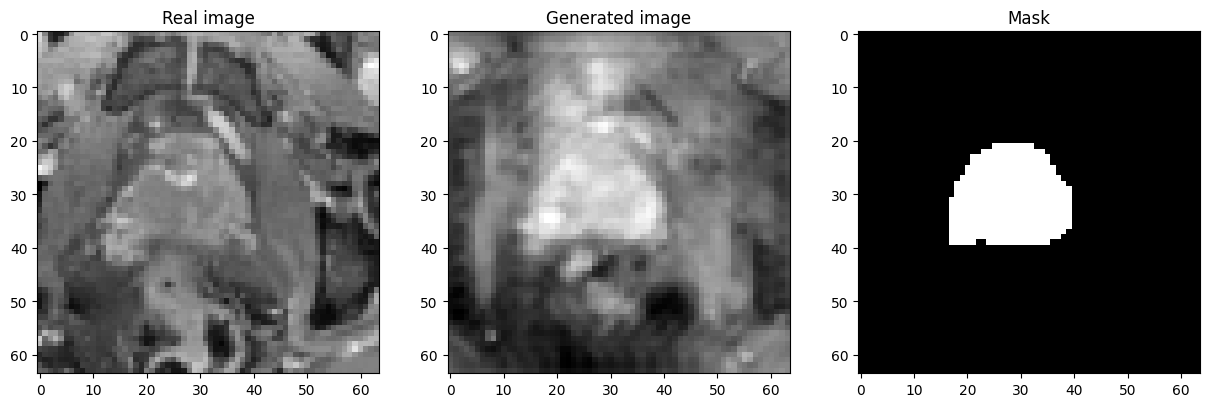

In [24]:
# Select a random image mask pair
# random_idx = random.randint(0, BATCH_SIZE - 1)
random_idx = 1259
mr_prostate = total_prostate[random_idx]
mask = total_segment[random_idx].to(mr_prostate.dtype).unsqueeze(0)

with torch.no_grad():
    noise = torch.randn(1, Z_DIM)
    image_sample = cvae_model.generator(noise, mask)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(mr_prostate[0], cmap="gray")
    ax[0].set_title("Real image")
    ax[1].imshow(image_sample[0][0], cmap="gray")
    ax[1].set_title("Generated image")
    ax[2].imshow(mask[0][0], cmap="gray")
    ax[2].set_title("Mask")
print(mr_prostate[0].min(), mr_prostate[0].max())

In [11]:
pixel_count = []
# Loop over segmentation inside dataloader
for total_prostate, total_segment in dataloader:
    # Loop over individual segmentations
    for segment in total_segment:
        # Calculate number of pixels
        segment = segment.squeeze().numpy()
        num_pixels = np.sum(segment)
        pixel_count.append(int(num_pixels))
pc_array = np.array(pixel_count)

In [ ]:
pc_bins, pc_bin_edges = np.histogram(pc_array, 16)
binned_masks = cvae_generate.bin_masks(dataloader, pc_bin_edges)

In [130]:
import imp
imp.reload(utils)
cvae_paths = [
    path
    for path in DATA_DIR.glob("*")
    if any(part.startswith("c") for part in path.parts)
]

# load training data and create DataLoader with batching and shuffling
cvae_dataset = utils.CombinedProstateMRDataset(cvae_paths, IMAGE_SIZE)
cvae_dataloader = DataLoader(
    cvae_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

# Obtain all images in a tensor
cvae_total_prostate, cvae_total_segment = next(iter(cvae_dataloader))


In [ ]:
# Select a random image mask pair
random_idx = random.randint(0, BATCH_SIZE - 1)
mr_prostate = cvae_total_prostate[random_idx]
mask = cvae_total_segment[random_idx].to(mr_prostate.dtype).unsqueeze(0)

with torch.no_grad():
    noise = torch.randn(1, Z_DIM)
    image_sample = cvae_model.generator(noise, mask)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(mr_prostate[0], cmap="gray")
    ax[0].set_title("Real image")
    ax[1].imshow(image_sample[0][0], cmap="gray")
    ax[1].set_title("Generated image")
    ax[2].imshow(mask[0][0], cmap="gray")
    ax[2].set_title("Mask")

In [131]:
cvae_pixel_count = []
# Loop over segmentation inside dataloader
for cvae_total_prostate, cvae_total_segment in cvae_dataloader:
    # Loop over individual segmentations
    for cvae_segment in cvae_total_segment:
        # Calculate number of pixels
        cvae_segment_np = cvae_segment.squeeze().numpy()
        num_pixels = np.sum(cvae_segment_np)
        cvae_pixel_count.append(int(num_pixels))
cvae_pc_array = np.array(cvae_pixel_count)

In [114]:
total_pc_array = np.array(pixel_count + cvae_pixel_count)
total_pc_bins, total_pc_bin_edges = np.histogram(total_pc_array, 16)
print(pc_bins, sum(pc_bins))
print(total_pc_bins, sum(total_pc_bins))

[470  76 105 114 111 110  54  41  45  51  42  34  14   9   9   5] 1290
[1444  392  105  114  111  110   54   41   45   51   42   34   14    9
    9    5] 2580


c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20182717\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_in

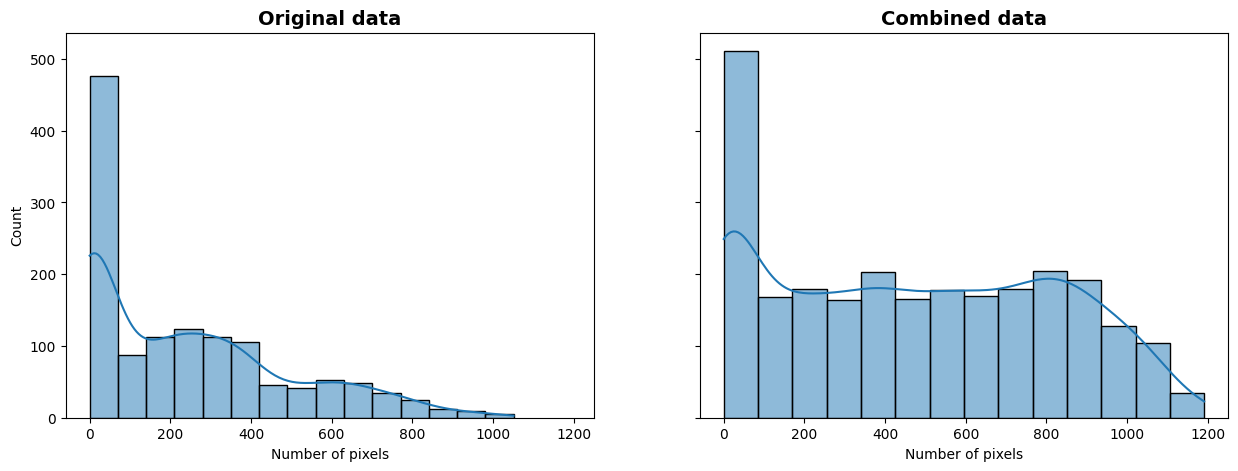

In [132]:
# plt.hist(pixel_count + cvae_pixel_count, bins=16)
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
sns.histplot(pixel_count, kde=True, ax=ax[0])
sns.histplot(pixel_count + cvae_pixel_count, kde=True, ax=ax[1])
ax[0].set_title("Original data", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Number of pixels")
ax[1].set_title("Combined data", fontsize=14, fontweight="bold")
ax[1].set_xlabel("Number of pixels");

In [54]:
real_path = r"D:\TUe\8DM20\8DM20-Capita-Selecta\DevelopmentData\p102"
cvae_path = r"D:\TUe\8DM20\8DM20-Capita-Selecta\DevelopmentData\cvae (1)"
real_mask = sitk.GetArrayFromImage(sitk.ReadImage(real_path + r"\prostaat.mhd"))
cvae_mask = sitk.GetArrayFromImage(sitk.ReadImage(cvae_path + r"\prostaat.mhd"))
cvae_mr = sitk.GetArrayFromImage(sitk.ReadImage(cvae_path + r"\mr_bffe.mhd"))
print(real_mask.shape)
print(cvae_mask.shape)

(86, 333, 271)
(86, 1, 64, 64)


Text(0.5, 1.0, 'Mask')

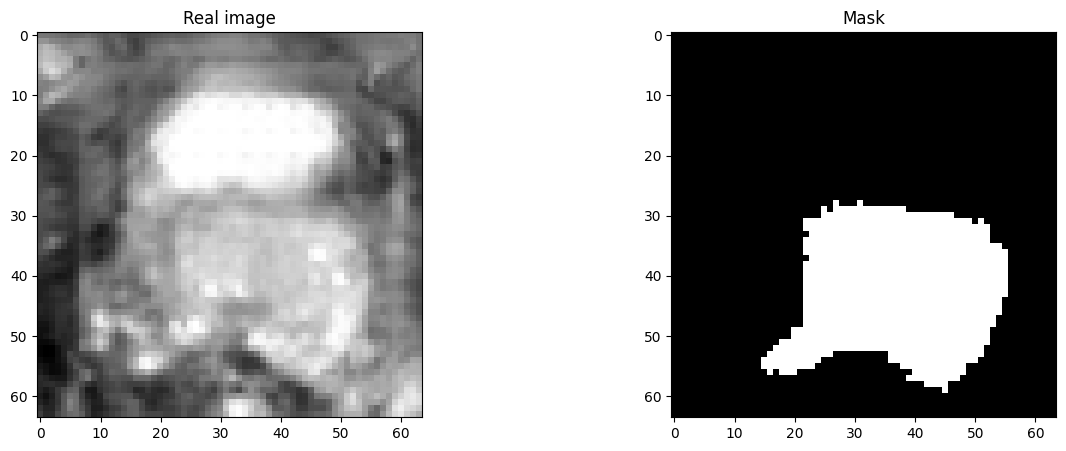

In [58]:
idx = 50
mr_prostate = cvae_mr[idx]
mask = cvae_mask[idx]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(mr_prostate[0], cmap="gray")
ax[0].set_title("Real image")
ax[1].imshow(mask[0], cmap="gray")
ax[1].set_title("Mask")

In [142]:
a = np.array([1,2])
b = np.array([1,2,3])
print(np.stack([a.flatten(), b.flatten()]), 1)

ValueError: all input arrays must have the same shape